# Example: Boltzmann Weighted Expected Return and Variance
This example will familiarize students with computing Boltzmann weighted return distributions. From the definition of discrete expectation, we know the expected excess return for firm $i$, denoted by $\mathbb{E}\left(R_{i}\right)$, is given by:
\begin{equation}
\mathbb{E}\left(R_{i}\right) = \sum_{t=1}^{T}p_{i}(t)\cdot{R_{i,t}}
\end{equation}
while the variance of the excess return, denoted by $\text{Var}\left(R_{i}\right)$, is given by:
\begin{equation}
\text{Var}\left(R_{i}\right) = \sum_{t=1}^{T}\left[R_{i,t} - \mathbb{E}\left(R_{i}\right)\right]^{2}\cdot{p_{i}}(t)
\end{equation}

where $R_{i,t}$ is the excess return for firm $i$ at time $t$, $p_{i}(t)$ denotes the probability of observing the excess return $R_{i,t}$ at time $t$ for firm $i$, $t=1,\dots,{T}$ denotes the sample index, i.e., the trading days we have in the dataset,
where the probability $\sum_{t}p_{i}(t) = 1$. Let the probability factors $p(t)$ follow a [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution):
\begin{equation*}
    p(t) = \frac{1}{Z}\cdot\exp(-\lambda\cdot\epsilon_{t})
\end{equation*}
where the partition function $Z \equiv \sum_{t=1}^{T}\exp(-\lambda\cdot\epsilon_{t})$.
The parameter $\lambda\geq{0}$ controls the rate of decay, while $\epsilon_{t}>0$ is a pseudo energy at time $t$;
we model the pseudo energy as $\epsilon_{t} = t$. Then, the Boltzmann weighted expected excess return is given by: 
$$
\begin{equation}
    \mathbb{E}_{B}\left(R_{i}\right) = \frac{1}{Z}\cdot\sum_{t=1}^{T}\exp\left(-\lambda\cdot{t}\right)\cdot{R}_{i,t}
\end{equation}
$$
Depending upon how we choose the decay parameter $\lambda$ and the pseudo energies, we can recover 
equally weighted, past, or present exponentially weighted expectations. 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
Precompiling project...
  ✓ VLQuantitativeFinancePackage
  1 dependency successfully precompiled in 3 seconds. 282 already precompiled.
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2`
 

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable. The dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable.

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [11]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value), and we'll specify the number of trading days to simulate in the `T` variable:

In [13]:
Δt = (1.0/252.0);
T = 48;
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;
risk_free_rate = 0.045;

## Compute the Weighted Expected Return and Variance
Let's start by computing the unweighted excess annualized growth rates for all firms in the `dataset`; we'll compare these values with their weighted counterparts. To calculate the unweighted values, we pass the `dataset` and `list_of_all_firms` variables to the `log_return_matrix(...)` function along with `risk_free_rate` and the sampling frequency of the data, i.e., we use daily data so we'll use a single trading day
* The `log_return_matrix(...)` function returns a $\dim{T}\times\dim\mathcal{D}$ matrix with $\dim{T}$ rows and $\dim\mathcal{D}$ columns holding the annualized excess return values for each firm for each trading period, i.e., time is on the rows and firms are on the columns. We store this data in the `all_firms_growth_matrix` variable.

In [15]:
all_firms_growth_matrix = log_return_matrix(dataset, list_of_all_firms, Δt = (1.0/252.0), 
    risk_free_rate = risk_free_rate);

### Implement Boltzmann Weighting Scheme
Next, specify a ticker that we will explore, and save it in the `ticker_of_interest` variable. Then, using that `ticker`, let's pull the price data from the `dataset` and reverse the order using the [Julia |> operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) and the [built-in reverse function](https://docs.julialang.org/en/v1/base/arrays/#Base.reverse-Tuple{AbstractVector})
* __Why reverse the order of the data?__ By default, the daily price data is organized from `oldest` to `newest`, i.e., the more recent values are at the bottom of the dataset. Our weighing algorithm iterates through the data in reverse order, i.e., we weigh the recent data more than the past data. We could write the `for-loop` to go backward or reverse the data order (we have chosen the latter).

In [17]:
ticker_of_interest = "SPY";
𝒟 = dataset[ticker_of_interest] |> reverse;

Now that we have a `ticker`, find the index of that ticker in the `list_of_all_firms` using the [findfirst function](https://docs.julialang.org/en/v1/base/arrays/#Base.findfirst-Tuple{Function,%20Any}). We then select that column of data from the `all_firms_growth_matrix` variable, i.e., we select the unweighted excess annualized growth rate values computed previously for `ticker` and save these values in the `R` variable:

In [19]:
R = findfirst(x->x==ticker_of_interest,list_of_all_firms) |> i-> all_firms_growth_matrix[:,i]; # unweighted excess return

The primary compute loop calculates the weight vector `W` and the excess return vector `R̄` for different values of the decay parameter `λ.` We store the `W` and `R̄` vectors as a [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) in the `weight_dictionary` where the `keys` are the decay parameter `λ` values.

In [21]:
weight_dictionary = Dict{Float64, NamedTuple}();
Λ = range(0.0, stop=0.05, length=6) |> collect
number_of_trading_periods = 𝒟 |> nrow;
for λ ∈ Λ

    W = zeros(number_of_trading_periods-1)
    R̄ = zeros(number_of_trading_periods-1)
    
    for i ∈ 2:number_of_trading_periods
        ϵ = (i - 1);
        S₁ = 𝒟[i, :volume_weighted_average_price];
        S₂ = 𝒟[i-1, :volume_weighted_average_price];

        W[i-1] = exp(-λ*ϵ);
        R̄[i-1] = ((1/Δt)*log(S₂/S₁) - risk_free_rate);
    end
    weight_dictionary[λ] = (WA = W, RA = R̄);
end

### Compare the unweighted and weighted expected excess growth rate and variance
Now that we have calculated the weights `W` for different decay parameter `λ` values, we can compute the weighted expected excess return and variance and consider how they differ from their unweighted counterparts.
Our analysis begins with selecting a decay parameter value, which we store in the `λ̄` variable. This value is then used to extract the corresponding data from the `weight_dictionary,` providing us with the weights `W` and the excess return vector `R̄.` The expected return, a key metric in our analysis, is derived from the [dot product](https://en.wikipedia.org/wiki/Dot_product) of the `W` and `R̄` vectors, divided by the partition function `Z.`
* `Check:` We included the `λ = 0` case in the `weight_dictionary`. For `λ = 0`, the unweighted and weighted expected excess returns should be equal. We'll check this using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox). If they are __not__ approximately equal to some tolerance, an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown.

In [23]:
λ̄ = 0.0;
W = weight_dictionary[λ̄].WA
R̄ = weight_dictionary[λ̄].RA;
Z = sum(W);
expected_value_weighted = (1/Z)*dot(W,R̄);
expected_value_unweighted = mean(R)
@assert isapprox(expected_value_weighted,expected_value_unweighted, atol=1e-6) # atol = absolute tolerance

#### Expected value
Now that we have checked our values, let's select a non-zero value for the `λ̄` parameter and recompute the weighted expected excess return, we store this value in the `expected_value_weighted` variable:

In [25]:
λ̄ = 0.02; # select a value in [0.01, 0.05]
W = weight_dictionary[λ̄].WA
R̄ = weight_dictionary[λ̄].RA;
Z = sum(W);
expected_value_weighted = (1/Z)*dot(W,R̄);
expected_value_unweighted = mean(R);
println("Decay parameter $(λ̄) gives weighted expected annualized excess growth rate = $(expected_value_weighted). Unweighted value: $(expected_value_unweighted)")

Decay parameter 0.02 gives weighted expected annualized excess growth rate = 0.2739829553810115. Unweighted value: 0.04961549125844327


#### Variance
Once we have the expected return, we can compute the growth rate variance. The variance equals the [dot product](https://en.wikipedia.org/wiki/Dot_product) between the $\left[R_{i,t} - \mathbb{E}\left(R_{i}\right)\right]^{2}$ terms and the weight vector `W` normalized by the partition function `Z.`. Let's use the same value of the `λ̄` parameter as above.

In [27]:
squared_diff_terms = [(R[j] - expected_value_weighted)^2 for j ∈ eachindex(R̄)];
variance_weighted = (1/Z)*dot(W,squared_diff_terms);
variance_unweighted = var(R);
println("Decay parameter $(λ̄) gives weighted excess growth rate variance = $(variance_weighted). Unweighted variance: $(variance_unweighted)")

Decay parameter 0.02 gives weighted excess growth rate variance = 5.365198330183917. Unweighted variance: 6.358407623645658


## Visualize the weights $W(t)$ and probability $p(t)$ as a function (backward) time and $\lambda$.
Different decay parameter `λ` values give different values for the expected excess growth rate and variance. Let's dive deeper into what's going on for different choices of `λ.`
* `Unhide` the code block below to see how we plot the $W(t)$ values for different choices of the $\lambda$-hyperparameter. At `t = 1` (approximately now) $W_{\lambda}(t)\simeq{1}$, i.e., we weigh the current time highly. However, as we go backward in time $t\rightarrow\infty$, the weight associated with a growth rate value goes to zero, i.e., $\lim_{t\rightarrow\infty}W_{\lambda}(t)\rightarrow{0}$.
* When the $\lambda$-hyperparameter is zero, we consider all the data equally, i.e., $W=1\,\forall{t}$.

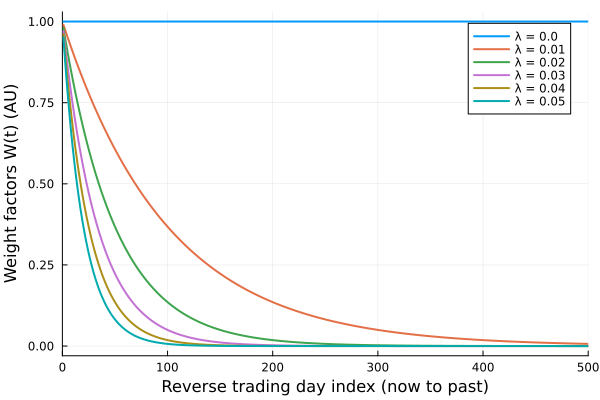

In [145]:
let 
    p = plot();
    for λ ∈ Λ
        W = weight_dictionary[λ].WA;
        plot!(W, lw=2, label="λ = $(λ)", xlim=(0.0,500))
    end
    current();
    xlabel!("Reverse trading day index (now to past)", fontsize=18)
    ylabel!("Weight factors W(t) (AU)", fontsize=18)
end

`Unhide` the code block below to see how we computed and plotted the probability factors $p(t)$ for different choices of the for different choices of the $\lambda$-hyperparameter. From the plot, we can see that the computed values of the probability are [Boltzmann distributed](https://en.wikipedia.org/wiki/Boltzmann_distribution) except for the $\lambda = 0$ case, which is uniform across time.
* As the $\lambda$ increases, the near-dated values have increased importance (higher probability), but larger values of $\lambda$ lead to faster decay, i.e., the window of values used to compute the expected excess annualized growth rate and variance are smaller.

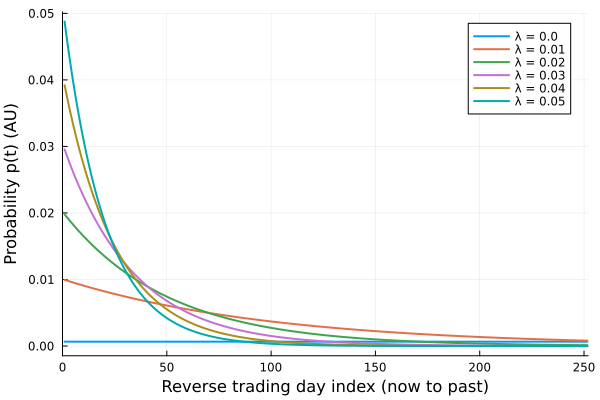

In [135]:
let
    p = plot();
    for λ ∈ Λ
        W = weight_dictionary[λ].WA;
        Z = sum(W);
        plot!((1/Z)*W, lw=2, label="λ = $(λ)", xlim=(0.0,252))
    end
    current();
    xlabel!("Reverse trading day index (now to past)", fontsize=18)
    ylabel!("Probability p(t) (AU)", fontsize=18)
end

### What are the different $\lambda$ values doing?
Let's select a value for the decay parameter and store it in the `λ̄` variable. Then, calculate and visualize the individual $p_{i}(t)\cdot{R_{i,t}}$ terms in the discrete expectation summation, i.e., the probability of observing a particular excess return value multiplied by that value. We'll store the weighted terms in the `terms_weighted` variable and the unweighted terms in the `terms_unweighted` variable.
* The difference between the weighted and unweighted excess growth rate sequences comes from the discrete probability factors $p(t)$. In the case of an unweighted sequence, all values are equally likely; thus, the probabilities follow a [discrete Uniform distribution](https://en.wikipedia.org/wiki/Discrete_uniform_distribution). However, for the weighted sequence, the probabilities are [Boltzmann distributed](https://en.wikipedia.org/wiki/Boltzmann_distribution).

In [183]:
λ̄ = 0.01;
W = weight_dictionary[λ̄].WA
R̄ = weight_dictionary[λ̄].RA;
Z = sum(W);
terms_weighted = (1/Z)*[W[i]*R̄[i] for i ∈ eachindex(R̄)];
terms_unweighted = (1/(number_of_trading_periods-1))*R;

`Unhide` the code block below to see how we plotted the individual $p_{i}(t)\cdot{R_{i,t}}$ terms for the weighted (red) and unweighted (orange) annualized excess growth rates. For different values of the decay parameter `λ̄`, we focus on (and emphasize) different time regions. Larger values of the `λ̄` parameters consider less, but more recent data, while the `λ̄ = 0` case (unweighted) considers all the data with an equal weight.

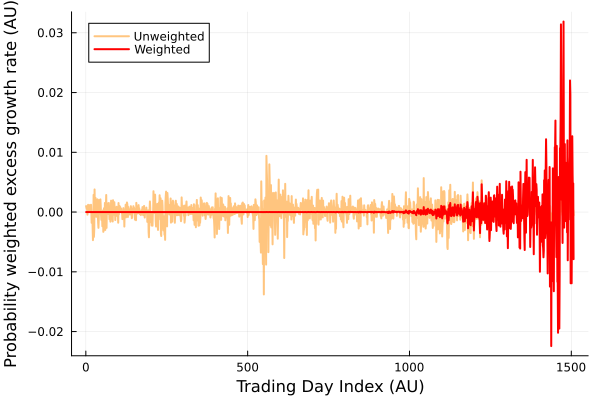

In [185]:
plot(terms_unweighted, lw=2, c=:darkorange, alpha=0.5, label="Unweighted")
plot!(terms_weighted |> reverse, c=:red, label="Weighted", lw=2)
xlabel!("Trading Day Index (AU)",fontsize = 18)
ylabel!("Probability weighted excess growth rate (AU)",fontsize = 18)

Finally, we can visualize the annualized excess return distributions for the weighted and unweighted cases. As the decay parameter $\lambda\rightarrow\infty$, the distribution becomes focused on recent values.
* `Unhide` the code below to see how we plotted the probability density for the weighted and unweighted cases.

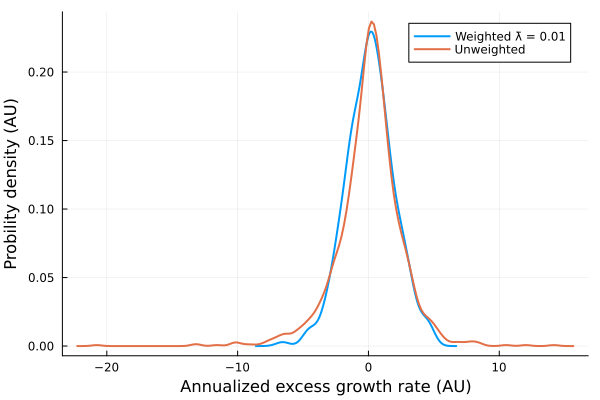

In [189]:
p = (1/Z)*W
d = findall(x-> x ≥ (1/(number_of_trading_periods-1)),p) |> i-> R̄[i];
density(d, lw=2, label="Weighted λ̄ = $(λ̄)")
density!(R, lw=2, label="Unweighted")
xlabel!("Annualized excess growth rate (AU)", fontsize=18)
ylabel!("Probility density (AU)", fontsize=18)

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.